# Import Packages

In [1]:
import sys
import re
import html
import json
import time
import warnings
from collections import deque

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import (
    normalize, StandardScaler, LabelEncoder, MaxAbsScaler, Normalizer
)
from scipy.sparse import issparse

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import umap

from sklearn.metrics import (
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    confusion_matrix, accuracy_score, make_scorer
)
from scipy.optimize import linear_sum_assignment

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from skopt import BayesSearchCV
from skopt.space import Categorical
from skopt.callbacks import DeltaYStopper, DeadlineStopper
from skopt.utils import point_asdict

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

# Load Data

In [2]:
df_cleaned = pd.read_csv("cleaned_tweets.csv")
texts = df_cleaned["clean_text"].astype(str).tolist()

df_cleaned_sample = pd.read_csv("cleaned_sample_tweets.csv")

# TF-IDF

In [3]:
# ---------------------------
# CONFIG
# ---------------------------
RANDOM_STATE = 42
TOTAL_ITERS  = 60         
N_CLUSTERS   = 3 

In [4]:
# Encode labels (fit on FULL so sample + full share the same mapping)
le = LabelEncoder()
le.fit(df_cleaned["airline_sentiment"].astype(str))
y_full_enc   = le.transform(df_cleaned["airline_sentiment"].astype(str))
y_sample_enc = le.transform(df_cleaned_sample["airline_sentiment"].astype(str))

# ---------------------------
# TF-IDF (SAMPLE) + zero-row mask  ← BayesSearch uses THIS
# ---------------------------
tfidf_sample = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, max_features=5000, norm='l2')
X_sample = tfidf_sample.fit_transform(df_cleaned_sample['clean_text'].astype(str))
# mask out rows that are empty after TF-IDF (zero vectors)
nz_mask_s   = X_sample.getnnz(axis=1) > 0
X_sample_nz = X_sample[nz_mask_s]
y_sample_enc_nz = y_sample_enc[nz_mask_s]

print(f"[SAMPLE] TF-IDF: {X_sample.shape} -> non-zero: {X_sample_nz.shape}")

# ---------------------------
# TF-IDF (FULL) + zero-row mask  ← Final refit/eval uses THIS
# ---------------------------
tfidf_full = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9, max_features=5000, norm='l2')
X_full = tfidf_full.fit_transform(df_cleaned['clean_text'].astype(str))
# mask out rows that are empty after TF-IDF (zero vectors)
nz_mask_f   = X_full.getnnz(axis=1) > 0
X_full_nz   = X_full[nz_mask_f]
y_full_enc_nz = y_full_enc[nz_mask_f]

print(f"[FULL ] TF-IDF: {X_full.shape} -> non-zero: {X_full_nz.shape}")

[SAMPLE] TF-IDF: (2928, 1118) -> non-zero: (2896, 1118)
[FULL ] TF-IDF: (14639, 4756) -> non-zero: (14588, 4756)


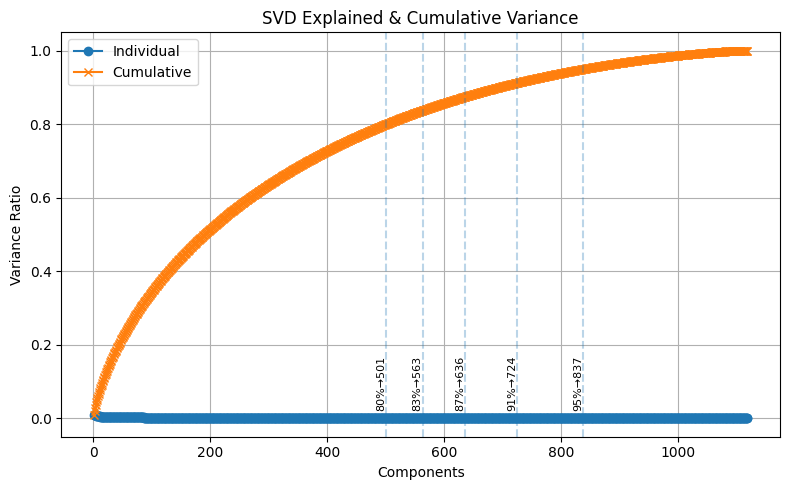

SVD n_components candidates (80–95% cum var): [501, 563, 636, 724, 837]


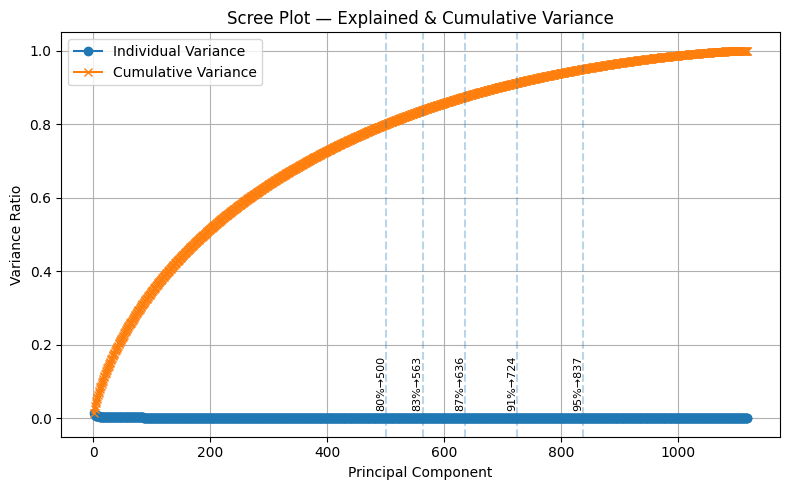

PCA n_components candidates (80–95% cumulative variance): [500, 563, 636, 724, 837]

=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===
[Bayes] iter   4/60 ( 6.7%) | last 25.19s avg 25.19s | elapsed  0.4m ETA ~23.5m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter   8/60 (13.3%) | last 22.73s avg 23.96s | elapsed  0.8m ETA ~20.8m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  12/60 (20.0%) | last  7.81s avg 18.58s | elapsed  0.9m ETA ~14.9m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  16/60 (26.7%) | last  8.97s avg 16.17s | elapsed  1.1m ETA ~11.9m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  20/60 (33.3%) | last  8.84s avg 14.71s | elapsed  1.2m ETA ~ 9.8m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  24/60 (40.0%) | last  8.71s avg 13.71s | elapsed  1.4m ETA ~ 8.2m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  28/60 (46.7%) | last  9.15s avg 13.06s | elapsed  1.5m ETA ~ 7.0m | branch svd+kmeans (Using TF-IDF)
[Bayes] iter  32/60 (53.3%) | last  9.05s avg 12.5

,estimator,ClusteringPipeline()
,search_spaces,"[{'model': Categorical(c...), prior=None), 'n_components': Categorical(c...), prior=None), 'reducer': Categorical(c...), prior=None)}, {'cov_type': Categorical(c...), prior=None), 'model': Categorical(c...), prior=None), 'n_components': Categorical(c...), prior=None), 'reducer': Categorical(c...), prior=None)}, ...]"
,optimizer_kwargs,None
,n_iter,60
,scoring,None
,fit_params,None
,n_jobs,-1
,n_points,4
,iid,'deprecated'
,refit,True
,cv,"[(array([ 0, ...shape=(2928,)), ...)]"


In [5]:
# ---------------------------
# Metrics
# ---------------------------
def hungarian_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(-cm)
    return cm[r, c].sum() / cm.sum()

def evaluate_full(X, y_true_int, labels, sil_metric):
    sil = silhouette_score(X, labels, metric=sil_metric)
    ari = adjusted_rand_score(y_true_int, labels)
    nmi = normalized_mutual_info_score(y_true_int, labels)
    acc = hungarian_accuracy(y_true_int, labels)
    return sil, ari, nmi, acc

# ---------------------------
# Prepare Data
# ---------------------------
texts_sample = df_cleaned_sample["clean_text"].astype(str).tolist()
texts_full   = df_cleaned["clean_text"].astype(str).tolist()

le = LabelEncoder()
le.fit(df_cleaned["airline_sentiment"].astype(str))
y_sample_enc = le.transform(df_cleaned_sample["airline_sentiment"].astype(str))
y_full_enc   = le.transform(df_cleaned["airline_sentiment"].astype(str))

# ---------------------------
# SVD Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------

def pick_svd_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    """
    Select a list of n_components based on cumulative explained variance for SVD.
    The function will pick k candidates based on variance thresholds between pct_low and pct_high.
    
    Parameters:
    - X: Input data matrix (sparse matrix is allowed)
    - pct_low: Minimum cumulative variance threshold (default 0.80)
    - pct_high: Maximum cumulative variance threshold (default 0.95)
    - k: Number of n_components to select (default 5)
    - max_components: Maximum number of components to consider (default None)
    - plot: Whether to plot the cumulative variance explained (default True)
    
    Returns:
    - comps_unique: List of selected n_components based on variance thresholds
    - cum: Cumulative explained variance for each component
    """
    if max_components is None:
        max_components = X.shape[1]
    
    # Scale data (Standardize)
    X_std = MaxAbsScaler().fit_transform(X)
    
    # Fit SVD
    svd = TruncatedSVD(n_components=max_components, random_state=42)
    svd.fit(X_std)
    
    # Explained variance and cumulative variance
    evr = svd.explained_variance_ratio_
    cum = np.cumsum(evr)

    # Determine thresholds and find components
    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # Deduplicate and preserve order
    seen = set()
    comps_unique = []
    for c in comps:
        if c not in seen:
            comps_unique.append(c)
            seen.add(c)

    # Ensure exactly k values (best-effort padding)
    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k - 1))
        candidate = min(max_components, comps_unique[-1] + step)
        if candidate not in seen:
            comps_unique.append(candidate)
            seen.add(candidate)
        else:
            candidate = min(max_components, candidate + 1)
            if candidate not in seen:
                comps_unique.append(candidate)
                seen.add(candidate)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    # Plot 
    if plot:
        xs = np.arange(1, len(evr) + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(xs, evr, marker='o', label='Individual')
        plt.plot(xs, cum, marker='x', label='Cumulative')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t * 100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('SVD Explained & Cumulative Variance')
        plt.xlabel('Components')
        plt.ylabel('Variance Ratio')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return comps_unique, cum

# Example usage with TF-IDF matrix (tfidf_matrix):
svd_candidates, _cum = pick_svd_candidates(X_sample, pct_low=0.80, pct_high=0.95, k=5, plot=True)
print("SVD n_components candidates (80–95% cum var):", svd_candidates)

# ---------------------------
# PCA Scree Plot + pick 5 n_components (80–95% cum var, evenly spaced)
# ---------------------------
def pick_pca_candidates(X, pct_low=0.80, pct_high=0.95, k=5, max_components=None, plot=True):
    # Convert sparse matrix to dense array and standardize
    X_dense = X.toarray() if hasattr(X, 'toarray') else X  # If it's sparse, convert it to dense
    Xs = MaxAbsScaler().fit_transform(X_dense)

    # If max_components is not provided, set it to the number of features (columns)
    if max_components is None:
        max_components = Xs.shape[1]

    # PCA fitting
    pca = PCA(n_components=max_components, random_state=42)
    pca.fit(Xs)
    
    # Explained variance ratio and cumulative variance
    evr = pca.explained_variance_ratio_
    cum = np.cumsum(evr)

    # Find n_components for the given variance thresholds (80%-95%)
    thresholds = np.linspace(pct_low, pct_high, k)
    comps = []
    for t in thresholds:
        idx = int(np.argmax(cum >= t)) + 1
        comps.append(idx)

    # Deduplicate and maintain order
    seen = set()
    comps_unique = []
    for c in comps:
        if c not in seen:
            comps_unique.append(c)
            seen.add(c)
    
    # Ensure exactly k values by padding 
    while len(comps_unique) < k:
        step = max(1, (comps_unique[-1] - comps_unique[0]) // (k-1))
        candidate = min(max_components, comps_unique[-1] + step)
        if candidate not in seen:
            comps_unique.append(candidate)
            seen.add(candidate)
        else:
            candidate = min(max_components, candidate + 1)
            if candidate not in seen:
                comps_unique.append(candidate)
                seen.add(candidate)
            else:
                break

    comps_unique = sorted(comps_unique)[:k]

    # Plotting the explained and cumulative variance
    if plot:
        xs = np.arange(1, len(evr) + 1)
        plt.figure(figsize=(8, 5))
        plt.plot(xs, evr, marker='o', label='Individual Variance')
        plt.plot(xs, cum, marker='x', label='Cumulative Variance')
        for t, c in zip(thresholds, comps):
            plt.axvline(c, linestyle='--', alpha=0.3)
            plt.text(c, 0.02, f'{int(t * 100)}%→{c}', rotation=90, va='bottom', ha='right', fontsize=8)
        plt.title('Scree Plot — Explained & Cumulative Variance')
        plt.xlabel('Principal Component')
        plt.ylabel('Variance Ratio')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return comps_unique, cum

# Assuming X_sample is TF-IDF matrix
pca_candidates, _cum = pick_pca_candidates(
    X_sample, pct_low=0.80, pct_high=0.95, k=5, plot=True
)
print("PCA n_components candidates (80–95% cumulative variance):", pca_candidates)

# Fixed UMAP candidate grids
umap_neighbors  = [15, 30, 45, 60, 75, 100, 150, 200]
umap_min_dist   = [0.1, 0.2, 0.3, 0.4, 0.5]
umap_components = [16, 32, 48, 64, 96, 128]

# ---------------------------
# ClusteringPipeline class (for BayesSearchCV)
# ---------------------------
_LAST_TRIAL = deque(maxlen=1)

class ClusteringPipeline(BaseEstimator):
    def __init__(self,
                 reducer='pca', n_components=50,
                 n_neighbors=15, min_dist=0.1, n_components_umap=16,
                 model='kmeans', cov_type='full', linkage='average'):
        self.reducer = reducer
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components_umap = n_components_umap
        self.model = model
        self.cov_type = cov_type
        self.linkage = linkage

    def fit(self, X, y=None):
        _LAST_TRIAL.clear()
        _LAST_TRIAL.append({
            'reducer'          : self.reducer,
            'n_components'     : self.n_components,
            'n_neighbors'      : self.n_neighbors,
            'min_dist'         : self.min_dist,
            'n_components_umap': self.n_components_umap,
            'model'            : self.model,
            'cov_type'         : self.cov_type,
            'linkage'          : self.linkage,
        })

        # Remove zero vectors
        nonzero_rows = np.where(np.sum(X, axis=1) > 0)[0]
        X_nonzero = X[nonzero_rows]

        # ---------------- Reducer ----------------
        if self.reducer == 'svd':
            X_std = MaxAbsScaler().fit_transform(X_nonzero)
            X_red = TruncatedSVD(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        elif self.reducer == 'pca':
            X_std = MaxAbsScaler().fit_transform(X_nonzero)
            X_red = PCA(n_components=self.n_components, random_state=RANDOM_STATE).fit_transform(X_std)
        else:
            X_l2 = normalize(X_nonzero)
            X_red = umap.UMAP(
                n_neighbors=self.n_neighbors,
                min_dist=self.min_dist,
                n_components=self.n_components_umap,
                metric='cosine',
                random_state=RANDOM_STATE,
                n_epochs=120,
                low_memory=True
            ).fit_transform(X_l2)

        # ---------------- Clustering ----------------
        if self.model == 'kmeans':
            X_use = normalize(X_red)
            labels = KMeans(n_clusters=3, n_init=10, algorithm='elkan', random_state=RANDOM_STATE).fit_predict(X_use)
            self.metric = "cosine"
        elif self.model == 'gmm':
            X_use = np.asarray(X_red, dtype=np.float64)
            try:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type
                ).fit_predict(X_use)
            except ValueError:
                labels = GaussianMixture(
                    n_components=3, n_init=10, random_state=RANDOM_STATE,
                    covariance_type=self.cov_type, reg_covar=1e-5
                ).fit_predict(X_use)
            self.metric = "euclidean"
        else:  # Agglo
            X_use = normalize(X_red)
            labels = AgglomerativeClustering(
                n_clusters=3, linkage=self.linkage, metric='cosine'
            ).fit_predict(X_use)
            self.metric = "cosine"

        # store for score()
        self.labels_ = labels
        self.X_use_  = X_use
        self.score_  = silhouette_score(X_use, labels, metric=self.metric)
        return self

    def score(self, X, y=None):
        return self.score_

# ---------------------------
# Bayesian Search Space 
# ---------------------------
search_spaces = [
    # SVD + KMeans
    {
        'reducer'      : Categorical(['svd'],        name='reducer'),
        'n_components' : Categorical(svd_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # SVD + GMM
    {
        'reducer'      : Categorical(['svd'],        name='reducer'),
        'n_components' : Categorical(svd_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # SVD + Agglo
    {
        'reducer'      : Categorical(['svd'],        name='reducer'),
        'n_components' : Categorical(svd_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },
    # PCA + KMeans
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['kmeans'],     name='model'),
    },
    # PCA + GMM
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['gmm'],        name='model'),
        'cov_type'     : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # PCA + Agglo (no 'ward' since metric='cosine')
    {
        'reducer'      : Categorical(['pca'],        name='reducer'),
        'n_components' : Categorical(pca_candidates, name='n_components'),
        'model'        : Categorical(['agglo'],      name='model'),
        'linkage'      : Categorical(['average','complete','single'], name='linkage'),
    },

    # UMAP + KMeans
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['kmeans'],      name='model'),
    },
    # UMAP + GMM
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['gmm'],         name='model'),
        'cov_type'          : Categorical(['full','tied','diag','spherical'], name='cov_type'),
    },
    # UMAP + Agglo
    {
        'reducer'           : Categorical(['umap'],  name='reducer'),
        'n_neighbors'       : Categorical(umap_neighbors,  name='n_neighbors'),
        'min_dist'          : Categorical(umap_min_dist,   name='min_dist'),
        'n_components_umap' : Categorical(umap_components, name='n_components_umap'),
        'model'             : Categorical(['agglo'],       name='model'),
        'linkage'           : Categorical(['average','complete','single'], name='linkage'),
    },
]

# --- progress/timing callback for BayesSearchCV (with robust fallback) ---
TOTAL_ITERS = 60  # keep in sync with BayesSearchCV(n_iter=...)

_timings = []
_start = [None]
_prev  = [None]

def _short_params(d):
    keys = [
        'reducer','n_components','n_neighbors','min_dist','n_components_umap',
        'model','cov_type','linkage'
    ]
    return {k: d[k] for k in keys if k in d}

def _infer_branch_from_space(space):
    """Infer branch name (reducer+model) from single-choice categories in subspace."""
    reducer = model = None
    for dim in getattr(space, "dimensions", []):
        cats = getattr(dim, "categories", None)
        if not cats or not hasattr(cats, "__iter__"):
            continue
        if len(cats) == 1:
            v = cats[0]
            if v in ("svd", "pca", "umap"):
                reducer = v
            elif v in ("kmeans", "gmm", "agglo"):
                model = v
    return f"{reducer or '?'}+{model or '?'}"

def progress_callback(res):
    import time, numpy as np
    now = time.perf_counter()
    if _start[0] is None:
        _start[0] = now
    if _prev[0] is not None:
        _timings.append(now - _prev[0])

    k = len(res.x_iters)
    avg = float(np.mean(_timings)) if _timings else 0.0
    elapsed = now - _start[0]
    remaining = max(TOTAL_ITERS - k, 0) * (avg if avg > 0 else 0.0)

    # Try to get the reducer/model from the latest evaluated point
    branch = None
    try:
        if res.x_iters:
            last_params = point_asdict(res.space, res.x_iters[-1])
            r, m = last_params.get("reducer"), last_params.get("model")
            if r and m:
                branch = f"{r}+{m}"
    except Exception:
        pass

    # Fallback: infer directly from this subspace definition
    if branch is None:
        branch = _infer_branch_from_space(res.space)

    last_dt = _timings[-1] if _timings else 0.0
    print(
        f"[Bayes] iter {k:>3}/{TOTAL_ITERS} ({k/TOTAL_ITERS:5.1%}) "
        f"| last {last_dt:5.2f}s avg {avg:5.2f}s "
        f"| elapsed {elapsed/60:4.1f}m ETA ~{remaining/60:4.1f}m "
        f"| branch {branch} (Using TF-IDF)",  # Added "(Using TF-IDF)" for clarity
        flush=True
    )
    _prev[0] = now
    return False

# ---------------------------
# Run Bayesian SearchCV for TF-IDF
# ---------------------------
n = X_sample.shape[0]  # Number of samples in the TF-IDF matrix
dummy_y = np.zeros(n, dtype=int)  # Dummy target variable
cv_full = [(np.arange(n), np.arange(n))]

search = BayesSearchCV(
    estimator=ClusteringPipeline(),
    search_spaces=search_spaces,           # defined search space for PCA/UMAP × KMeans/GMM/Agglo
    n_iter=TOTAL_ITERS,
    random_state=RANDOM_STATE,
    scoring=None,                          # uses estimator.score() (silhouette score)
    cv=cv_full,
    n_points=4,                            # parallel proposals
    n_jobs=-1,                             # parallel fits
    return_train_score=False
)

print("\n=== Running BayesSearchCV (PCA/UMAP × KMeans/GMM/Agglo) ===")

callbacks = [
    DeltaYStopper(delta=1e-4, n_best=15),
    progress_callback  # Callback for tracking progress and timing
]

# prime timers for clean first measurement
_prev[0] = time.perf_counter()
_start[0] = _prev[0]

# Fit the model using the TF-IDF matrix
search.fit(X_sample, dummy_y, callback=callbacks)

In [6]:
# ---------------------------
# Best per-branch (from SAMPLE search)
# ---------------------------
cvres = pd.DataFrame(search.cv_results_)
param_cols = [c for c in cvres.columns if c.startswith("param_")]
score_col  = "mean_test_score"

# ensure plain types
for c in param_cols:
    cvres[c] = cvres[c].apply(lambda x: x if isinstance(x, (str,int,float,type(None))) else str(x))

cvres["branch"] = cvres.apply(lambda r: f"{r.get('param_reducer','?')}+{r.get('param_model','?')}", axis=1)
best_idx   = cvres.groupby("branch")[score_col].idxmax()
best_rows  = cvres.loc[best_idx].reset_index(drop=True)

def _params_compact(d):
    order = ["reducer","model","n_components","n_neighbors","min_dist","n_components_umap","cov_type","linkage"]
    return ", ".join(f"{k}={d[k]}" for k in order if (k in d and pd.notnull(d[k])))

subset_records = []
for _, r in best_rows.iterrows():
    params = {p.replace("param_",""): r[p] for p in param_cols if pd.notnull(r[p])}
    subset_records.append({
        "branch": r["branch"],
        "best_sil_sample_cv": round(float(r[score_col]), 4),
        **params
    })

df_best_subset = pd.DataFrame(subset_records).sort_values("branch")
print("\n================ Best Parameters per Branch (CV on SAMPLE non-zero set) ================\n")
print(df_best_subset[[
    "branch","best_sil_sample_cv","reducer","model","n_components",
    "n_neighbors","min_dist","n_components_umap","cov_type","linkage"
]].to_string(index=False))

# ---------------------------
# Refit best per-branch on FULL data + metrics (cosine)
# ---------------------------
final_rows = []
for _, row in df_best_subset.iterrows():
    params = {}
    for k in ["reducer","model","n_components","n_neighbors","min_dist",
              "n_components_umap","cov_type","linkage"]:
        if k in row and pd.notnull(row[k]):
            v = row[k]
            if k in ["n_components","n_neighbors","n_components_umap"] and not pd.isna(v):
                v = int(v)
            if k == "min_dist" and not pd.isna(v):
                v = float(v)
            params[k] = v

    mdl = ClusteringPipeline(**params)
    mdl.fit(X_full_nz)     # fit on FULL non-zero TF-IDF
    labels = mdl.labels_

    # Evaluate (cosine) vs FULL labels
    y_eval = y_full_enc_nz
    sil, ari, nmi, acc = evaluate_full(mdl.X_use_, y_eval, labels, sil_metric='cosine')  # Added sil_metric='cosine'
    final_rows.append({
        "branch": row["branch"],
        "Silhouette(cosine)": round(sil, 3),
        "ARI": round(ari, 3),
        "NMI": round(nmi, 3),
        "Hungarian": round(acc, 3),
        "Params": _params_compact(params)
    })

df_final = pd.DataFrame(final_rows).sort_values("branch")
print("\n================ Final Evaluation on FULL (All branch winners, cosine eval) ================\n")
print(df_final[["branch","Silhouette(cosine)","ARI","NMI","Hungarian","Params"]].to_string(index=False))

# Quick winners
for metric in ["Silhouette(cosine)","ARI","NMI","Hungarian"]:
    r = df_final.loc[df_final[metric].idxmax()]
    print(f"\nWinner by {metric}: {r['branch']} | {metric}={r[metric]:.3f} | {r['Params']}")


================ Best Parameters per Branch (CV on SAMPLE non-zero set) ================

     branch  best_sil_sample_cv reducer  model  n_components  n_neighbors  min_dist  n_components_umap cov_type linkage
  pca+agglo              0.0159     pca  agglo         500.0          NaN       NaN                NaN      NaN average
    pca+gmm              0.1120     pca    gmm         500.0          NaN       NaN                NaN     tied     NaN
 pca+kmeans              0.0281     pca kmeans         500.0          NaN       NaN                NaN      NaN     NaN
  svd+agglo              0.0194     svd  agglo         563.0          NaN       NaN                NaN      NaN average
    svd+gmm              0.0934     svd    gmm         837.0          NaN       NaN                NaN     tied     NaN
 svd+kmeans              0.0148     svd kmeans         636.0          NaN       NaN                NaN      NaN     NaN
 umap+agglo              0.5848    umap  agglo           NaN         